Neural network learning
===
notebook written by Patrick van der Smagt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We start off with defining transfer functions.  These are the (nonlinear) functions $\phi$ in the neurons.

The implementation is a bit weird: it returns $y = \phi(x, \mathrm{False})$ or $s = \phi(y, \mathrm{True})$ where $y = \phi(x)$.  So if the second parameter is True, the first argument is interpreted to be $\phi(x)$ and is used to compute the derivative.  This is done for computational efficiency only.

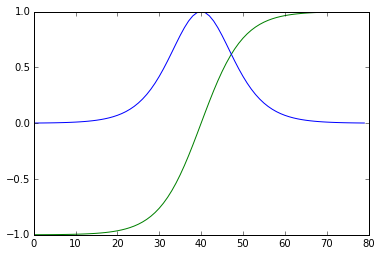

In [2]:
# sigmoid function.  returns y=sigmoid(x) or y' = sigmoid(y, True)
def sigmoid(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1/(1+np.exp(-x))
# tanh function.
def tanh(x,deriv=False):
    if(deriv==True):
        return 1-x*x
    return np.tanh(x)
# tanh function.
def linear(x,deriv=False):
    if(deriv==True):
        return 1
    return x
def rectifier(x, deriv=False):
    if (deriv==True):
        return (x > 0.)
    return x * (x > 0.)

actfunc = tanh              # transfer function
y = actfunc(np.arange(-4,4,.1))
plt.plot(y, "green");
s = actfunc(y,True)      # derivative
plt.plot(s, "blue");

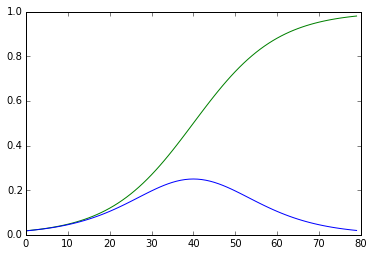

In [3]:
actfunc = sigmoid              # sigmoid transfer function
y = actfunc(np.arange(-4,4,.1))
plt.plot(y, "green");
s = actfunc(y,True)      # derivative
plt.plot(s, "blue");

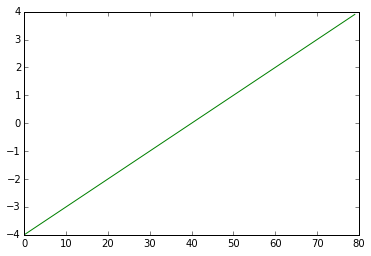

In [4]:
actfunc = linear              # linear transfer function
y = actfunc(np.arange(-4,4,.1))
plt.plot(y, "green");
s = actfunc(y,True)      # derivative
plt.plot(s, "blue");

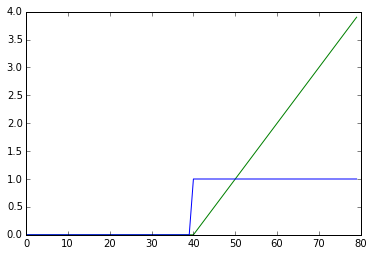

In [5]:
actfunc = rectifier              # rectifier transfer function
y = actfunc(np.arange(-4,4,.1))
plt.plot(y, "green");
s = actfunc(y,True)      # derivative
plt.plot(s, "blue");

Let's start off with a simple neural network with no hidden layer
---
This simple "neural network"---in this form also known as perceptron---does a simple forward pass, then computes the output errors, and uses those to adapt the weights.

Note that this thing does something like linear regression---and the error is a convex function in its parameters w.

perceptron output:
[[  2.15650550e-07]
 [  2.15650178e-07]
 [  9.99671606e-01]
 [  9.99671606e-01]]


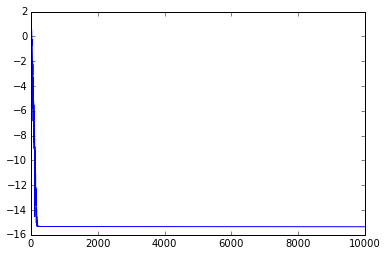

In [6]:
# input dataset.  Why is the third input always 1?
# To accommodate the bias

X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
z = np.array([[0,0,1,1]]).T

# seed random numbers
np.random.seed()

# initialize weights randomly with mean 0
# What happens if I start with w0 = 0?
# All inputs are not counted and the weights are not updated in either pass

w0 = 2*np.random.random((3,1)) - 1

loss = []

# the transfer function
transfer = tanh

# the learning rate
learn_rate = 0.1

# Momentum
momentum = 0.9
u_previous = 0.0

# make so many steps
for iter in xrange(10000):
    # forward propagation: layer 0 is the input
    l0 = X
    # layer one is dot product of l0 with w0, 
    # then the transfer function.  l1 is the output, i.e., y
    l1 = transfer(np.dot(l0,w0))

    # What is the residual?  Note that the error
    # equals the absolute residual.
    residual = z - l1
    # In the MLE interpretation we assume Gaussian errors in
    # the data.  So the loss is the sum of squared errors:
    loss.append(sum(i**2 for i in residual))

    # To find the residual at the inputs of the output unit, we
    # "propagate it through the unit", i.e., we multiply the
    # residual with the derivative of the transfer function.
    # We call the result "delta".  You can easily show that
    # this is mathematically correct.
    l1_delta = residual * transfer(l1,True)

    # Update weights.  How can this be extended with a momentum term?
    # w0 += learn_rate * np.dot(l0.T,l1_delta)
    
    # Extend with a momentum term
    gradient_delta = np.dot(l0.T,l1_delta)
    u_current = gradient_delta + momentum * u_previous
    w0 += learn_rate * u_current
    u_previous = u_current

print "perceptron output:"
print l1
plt.plot(np.log(loss));

Neural Network Implementation
----
A neural network with one hidden layer.  Biases are not added by this implementation (why is that no problem?).  Also, momentum is not implemented yet---please implement that to get faster learning, as soon as you know what is meant by "momentum".

In [8]:
class MyMLP:
    def __init__(self, n_inpt, n_hidden, n_output, hid_transfer = tanh, out_transfer = tanh):
        self.w0 = 2*np.random.random((n_inpt, n_hidden))
        self.w1 = 2*np.random.random((n_hidden, n_output))
        self.hid_transfer = hid_transfer
        self.out_transfer = out_transfer
        self.loss = []
    
    def ffnn_forward(self, X):
        l0 = X
        l1 = self.hid_transfer(np.dot(l0,self.w0))
        l2 = self.out_transfer(np.dot(l1,self.w1))
        return (l0,l1,l2)

    def NeuralNetwork(self, X, z, learn_rate = 0.1, momentum = 0.):
        # search direction for the weights in layers 1 and 0
        optim_step1 = 0
        optim_step0 = 0
        
        u_previous1 = 0.0
        u_previous0 = 0.0

        for j in xrange(60000):

            # Feed forward through layers 0, 1, and 2
            # l0 is the input layer
            # l1 is the hidden layer
            # l2 is the output layer
            (l0,l1,l2) = self.ffnn_forward(X)

            # (signed) error at the output
            residual = z - l2
            # the loss is the sum of squared errors
            self.loss.append(sum(i**2 for i in residual))

            # compute the delta.
            l2_delta = residual*self.out_transfer(l2,deriv=True)

            # back-propagate the output delta to the hidden units
            l1_error = l2_delta.dot(self.w1.T)

            # compute the delta at the hidden units
            l1_delta = l1_error * self.hid_transfer(l1,deriv=True)

            # optim_step1 = learn_rate*l1.T.dot(l2_delta)
            # optim_step0 = learn_rate*l0.T.dot(l1_delta)
            
            # Implement & extend with a momentum term
            gradient_delta1 = l1.T.dot(l2_delta)
            gradient_delta0 = l0.T.dot(l1_delta)
            
            u_current1 = gradient_delta1 + momentum * u_previous1
            u_current0 = gradient_delta0 + momentum * u_previous0
        
            optim_step1 = learn_rate * u_current1
            optim_step0 = learn_rate * u_current0

            self.w1 += optim_step1
            self.w0 += optim_step0
            
            u_previous1 = u_current1
            u_previous0 = u_current0

        plt.figure()
        plt.plot(np.log(self.loss));

Print the contour plot of this NN with a two-dimensional input

In [9]:
def nncontour (start, end, step, mlp):
    xx, yy = np.meshgrid( np.arange(start, end, step),  np.arange(start, end, step))
    x = np.array([[0,0,1]])
    z = np.zeros(( len(xx[:,0]), len(yy[:,0])) )
    for i in range(len(xx[:,0])):
        for j in range(len(yy[:,0])):
            x = [[xx[i,j], yy[i,j], 1]]
            (l0,l1,l2) = mlp.ffnn_forward(x)
            z[i, j] = l2.item(0)
    plt.figure()
    plt.contour(xx, yy, z)

Now do a typical silly example: the XOR function.  Please play around with the parameters of the NN: number of hiddens, the learning rate, the momentum...

output:
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


/home/vishal/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


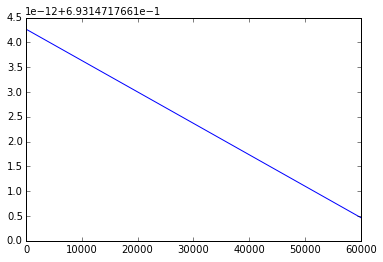

/home/vishal/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


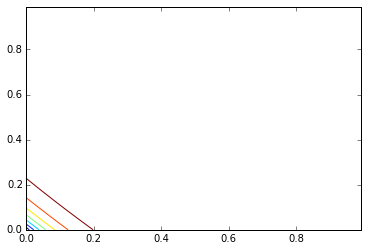

In [10]:
X = np.array([[0,0,1],
            [0,1,1],
            [1,0,1],
            [1,1,1]])
                
y = np.array([[0],
			[1],
			[1],
			[0]])

mlp_xor = MyMLP(X.shape[1], 10, y.shape[1])
mlp_xor.NeuralNetwork(X,y)
(l0, l1, l2) = mlp_xor.ffnn_forward(X)
print "output:"
print l2
nncontour(0,1, 0.01, mlp_xor)

Draw Hinton diagrams
---
Hinton diagrams can be used to represent weights in a NN.  Each box represents a single weight.  The colour of the box indicates the sign of the weight (black: negative; white: positive); the size of the box the size of the weight.

In [20]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        #max_weight = 0.5 * 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))
        max_weight = np.max(np.abs(matrix))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w)) / max_weight
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()


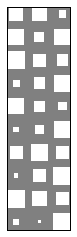

In [21]:
hinton(mlp_xor.w0)

Now try to fit a sine wave.  Experiment with, e.g., very many and very few hidden units.  Try it with and without momentum in the learning.

In [27]:
data = np.arange(-3,3,0.1) # is it enough data??
X = np.array([[x, 1] for x in data])
y = np.array([[np.sin(x)+np.random.randn()/10 for x in data]]).T
mlp_sin = MyMLP(X.shape[1],3,y.shape[1])

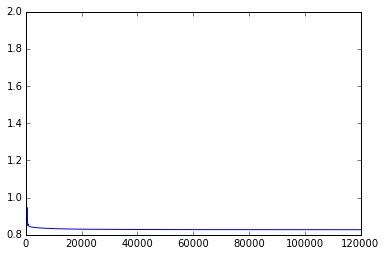

In [30]:
mlp_sin.NeuralNetwork(X,y,0.1,0.9) # After implementing momentum

Plot the output of the neural network over the training data.

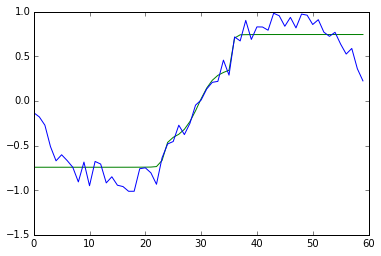

In [31]:
(l0,l1,l2) = mlp_sin.ffnn_forward(X)
plt.plot(l2, "green")
plt.plot(y, "blue")